In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC
from scipy.stats import alpha

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [5]:
from typing import Tuple, Sequence
from jax import jit, vmap, random

from functools import partial


@jit
def _sample_spherical_coords_inner(
    key,
    keys,
    n_samples,
    r_low,
    r_high,
    is_last_angle,
):
    """Inner function for sampling a single angle"""
    r = random.uniform(key, shape=(n_samples,), minval=r_low, maxval=r_high)
    max_val = jnp.where(is_last_angle, 2.0 * jnp.pi, jnp.pi)
    phi = random.uniform(keys, shape=(n_samples,), minval=0.0, maxval=max_val)
    return r, phi


@partial(jit, static_argnames=["n_dim", "n_samples"])
def sample_spherical_coords(
    key,
    n_dim,
    n_samples,
    r_low = 0.0,
    r_high = 1.0,
):
    """
    Generate uniform samples in n-dimensional spherical coordinates using JAX.

    Args:
        key: JAX random number generator key
        n_dim: Number of dimensions
        n_samples: Number of samples to generate
        r_low: Lower bound for radial coordinate
        r_high: Upper bound for radial coordinate

    Returns:
        Tuple containing:
        - Array of radial coordinates
        - Sequence of arrays containing angular coordinates
    """
    # Split the key for different random operations
    keys = random.split(key, n_dim)

    # Sample radial coordinate uniformly
    r = random.uniform(keys[0], shape=(n_samples,), minval=r_low, maxval=r_high)

    # Generate angular coordinates using vmap
    def sample_phi(key, is_last):
        max_val = jnp.where(is_last, 2.0 * jnp.pi, jnp.pi)
        return random.uniform(key, shape=(n_samples,), minval=0.0, maxval=max_val)

    # Create a list of boolean flags indicating if the angle is the last one
    is_last = jnp.arange(n_dim - 1) == (n_dim - 2)
    phis = vmap(sample_phi)(keys[1:], is_last)

    return r, phis


@jit
def spherical_to_cartesian(r, phis) :
    """
    Convert spherical coordinates to Cartesian coordinates using JAX.

    Args:
        r: Array of radial coordinates with shape (n_samples,)
        phis: Sequence of arrays containing angular coordinates,
              each with shape (n_samples,)

    Returns:
        Array of shape (n_samples, n_dim) containing Cartesian coordinates
    """

    n_dim = len(phis) + 1

    # Compute the Cartesian coordinates using vectorized operations
    sin_phis = jnp.sin(phis)
    cos_phis = jnp.cos(phis)

    # Initialize the Cartesian coordinates with the first coordinate
    x = r * cos_phis[0]

    # Compute the middle coordinates
    for i in range(1, n_dim - 1):
        x = jnp.column_stack((x, r * jnp.prod(sin_phis[:i], axis=0) * cos_phis[i]))

    # Compute the last coordinate
    last_coord = r * jnp.prod(sin_phis, axis=0)
    x = jnp.column_stack((x, last_coord))

    return x





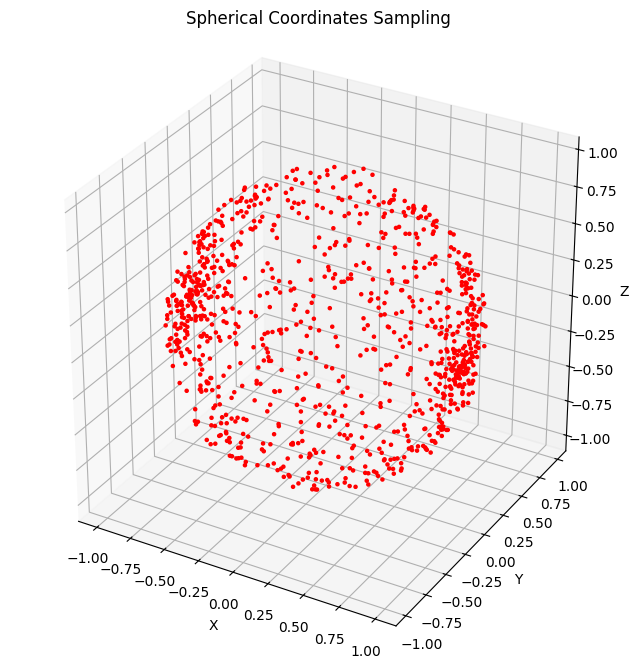

In [6]:
key = random.PRNGKey(42)

# Parameters
n_dim = 3  # Number of dimensions
n_samples = 1000  # Number of samples
r_low = 0.9  # Lower bound for radial coordinate
r_high = 1.0  # Upper bound for radial coordinate

# Generate samples
r, phis = sample_spherical_coords(key, n_dim, n_samples, r_low, r_high)

# Convert to Cartesian coordinates
x = spherical_to_cartesian(r, phis)
if n_dim <= 3:
    # Convert JAX arrays to NumPy for plotting
    x_np = jnp.asarray(x).copy()

    # Create the 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Create scatter plot
    scatter = ax.scatter(
        x_np[:, 0], x_np[:, 1], x_np[:, 2], alpha=1, c="red", marker="."
    )

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Spherical Coordinates Sampling")

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    # Show the plot
    plt.show()
else:
    print("Sampling and conversion completed successfully!")

In [7]:
def sample_annuli(D, n_samples, args):
    key = random.PRNGKey(42)
    """
    Samples from the annuli with specified radius

    args tuple:
        - n_dims : dimension of samples
        - n_samples : number of samples to be drawn
        - r_low : lower bound for radius (inner radius)
        - r_high: upper bound for radius (outer radius)
    """
    if args == []:
        print(
            """
            You must pass in args. The format of the list is:
                - r_low : lower bound for radius (inner radius)
                - r_high: upper bound for radius (outer radius)
              """
        )
    else:
        r_low = args[0]  # Lower bound for radial coordinate
        r_high = args[1]  # Upper bound for radial coordinate

    # Set random seed for reproducibility


    # Generate samples
    r, phis = sample_spherical_coords(key, D, n_samples, r_low, r_high)

    # Convert to Cartesian coordinates
    samples = spherical_to_cartesian(r, phis)

    return samples

In [13]:
def generate_bounds(start=0, stop=1, length=0.33):
    arr = jnp.arange(start, stop, length, dtype=jnp.float16)
    pairs = [[arr[i], arr[i + 1]] for i in range(len(arr) - 1)]
    return pairs

mean of sample norms: 0.95073223
samples shape [n_samples , D]: (1000, 3)


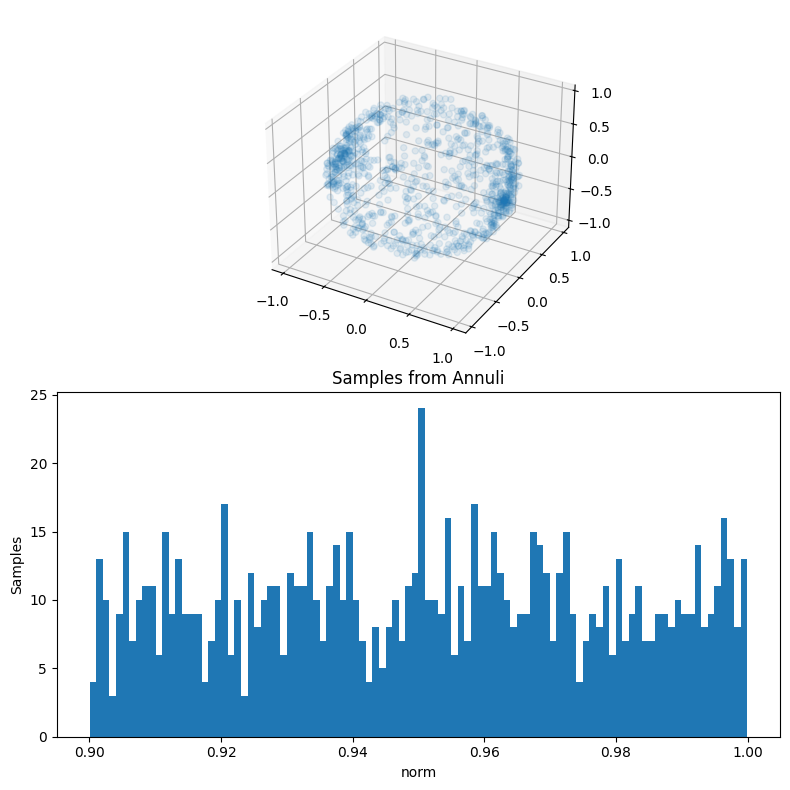

In [8]:
# Set random seed for reproducibility
key = random.PRNGKey(42)
samples = sample_annuli(D=3, n_samples=1000, args=[0.9, 1])
# Convert JAX arrays to NumPy for plotting
samples_np = jnp.asarray(samples).copy()
print("mean of sample norms:", jnp.mean(jnp.linalg.norm(samples, axis=1)))
print("samples shape [n_samples , D]:", samples.shape)
# Plot
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(211, projection="3d")
ax1.scatter(samples_np[:, 0], samples_np[:, 1], samples_np[:, 2], alpha=0.1)
ax2 = fig.add_subplot(212)
ax2.hist(jnp.linalg.norm(samples, axis=1), bins=100)
ax2.set_xlabel("norm")
ax2.set_ylabel("Samples")
plt.title("Samples from Annuli")
plt.tight_layout()
plt.show()

In [9]:
def logistic_posterior(X, y, D, prior_variance=1.0):
    # Parameter of interest: beta
    prior_var = prior_variance / D
    beta = numpyro.sample(
        "beta",
        dist.Normal(jnp.zeros(D), jnp.ones(D) * prior_var)
    )

    # Compute logits: beta.T @ X
    logits = jnp.dot(X, beta)

    # Deterministic site to track the probability p for each observation
    p = numpyro.deterministic("p", jax.scipy.special.expit(logits))

    # Likelihood: Y ~ Bern(p)
    # Using 'logits' directly is the standard, stable way to implement this
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

In [11]:
def run_mcmc(logistic_posterior, y_obs, X_data, D,num_chains, num_itter, step_size, bound):
    num_chains = num_chains

    #random init
    initial_beta = sample_annuli(D=D, n_samples=num_chains, args=bound)

    step_size = step_size

    kernel = HMC(
        logistic_posterior,
        step_size=step_size,
        trajectory_length=step_size,
        adapt_step_size=True
    )

    mcmc = MCMC(kernel,
                num_warmup=0,
                num_samples=num_itter,
                num_chains=num_chains)

    # --- Run Inference ---
    mcmc.run(k3,
             X=X_data,
             y=y_obs,
             D=D,
             init_params={"beta": initial_beta} # <--- random initialization
    )


    samples = mcmc.get_samples(group_by_chain=True)


    return samples



In [16]:
#data parms
N, D = 500, 500 # observations,  features
true_beta = jnp.zeros(D)

#mcmc parms
num_chains = 4
num_itter = 5000
step_size = 0.0001

bounds = generate_bounds(0,1,0.33)

data_dict = {}

for i,bound in enumerate(bounds):

    bound_str = f"[{bound[0]:.1f}, {bound[1]:.2f}]"

    print(bound_str)
    rng_key = random.PRNGKey(0)
    k1, k2, k3 = random.split(rng_key, 3)

    #draw X features
    X_data = random.normal(k1, (N, D)) * jnp.sqrt(1/D)

    # Generate binary observations
    y_obs = dist.Bernoulli(logits=jnp.dot(X_data, true_beta)).sample(k2)

    #draw samples
    samples = run_mcmc(logistic_posterior, y_obs, X_data, D, num_chains, num_itter, step_size, bound)


    beta_samples = samples["beta"]
    p_samples = samples["p"] # This contains the inferred p for every observation


    data_dict[bound_str] = [beta_samples, p_samples]



/var/folders/52/zlgr2hdx7nb8f3m4970zr2v40000gn/T/ipykernel_57615/2729332467.py:16: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,


[0.0, 0.33]


sample: 100%|██████████| 5000/5000 [00:00<00:00, 5594.26it/s, 1 steps of size 1.00e-04. acc. prob=1.00]


[0.3, 0.66]


sample: 100%|██████████| 5000/5000 [00:00<00:00, 5645.67it/s, 1 steps of size 1.00e-04. acc. prob=1.00]


[0.7, 0.99]


sample: 100%|██████████| 5000/5000 [00:00<00:00, 5733.42it/s, 1 steps of size 1.00e-04. acc. prob=1.00]


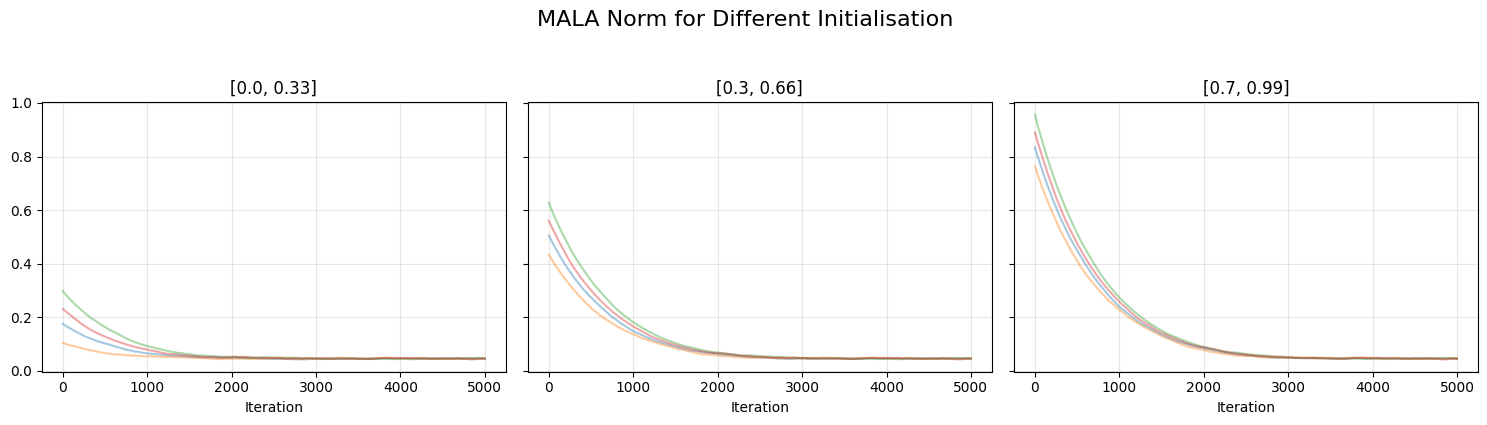

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, sharex=True)
keys = data_dict.keys()
for i, key in enumerate(keys):

    # 1. Get the samples
    beta_samples = data_dict[key][0]
    beta_samples.shape


    # 2. CALCULATE FIRST
    beta_norms = jnp.linalg.norm(beta_samples, axis=-1)


    # 3. THEN PLOT
    ax = axes[i]
    ax.plot(beta_norms.T, alpha=0.4)

    ax.set_title(key)
    ax.set_xlabel("Iteration")

    ax.grid(True, alpha=0.3)

# Move tight_layout outside the loop for better performance
fig.suptitle("MALA Norm for Different Initialisation", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [61]:
#data parms
N, D = 10, 10 # observations,  features
true_beta = jnp.zeros(D)

#mcmc parms
num_chains = 4
num_itter = 1000
step_size = 0.01

bounds = generate_bounds(0,1,0.33)

data_dict = {}

for i,bound in enumerate(bounds):

    bound_str = f"[{bound[0]:.1f}, {bound[1]:.2f}]"

    print(bound_str)
    rng_key = random.PRNGKey(0)
    k1, k2, k3 = random.split(rng_key, 3)

    #draw X features
    X_data = random.normal(k1, (N, D)) * jnp.sqrt(1/D)

    # Generate binary observations
    y_obs = dist.Bernoulli(logits=jnp.dot(X_data, true_beta)).sample(k2)

    #draw samples
    samples = run_mcmc(logistic_posterior, y_obs, X_data, D, num_chains, num_itter, bound)


    beta_samples = samples["beta"]
    p_samples = samples["p"] # This contains the inferred p for every observation


    data_dict[bound_str] = [beta_samples, p_samples]

[0.0, 0.33]


/var/folders/52/zlgr2hdx7nb8f3m4970zr2v40000gn/T/ipykernel_56809/4110224561.py:16: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,
sample: 100%|██████████| 1000/1000 [00:00<00:00, 9093.70it/s, 1 steps of size 1.00e-02. acc. prob=1.00]


[0.3, 0.66]


sample: 100%|██████████| 1000/1000 [00:00<00:00, 9191.18it/s, 1 steps of size 1.00e-02. acc. prob=1.00]


[0.7, 0.99]


sample: 100%|██████████| 1000/1000 [00:00<00:00, 8641.24it/s, 1 steps of size 1.00e-02. acc. prob=1.00]


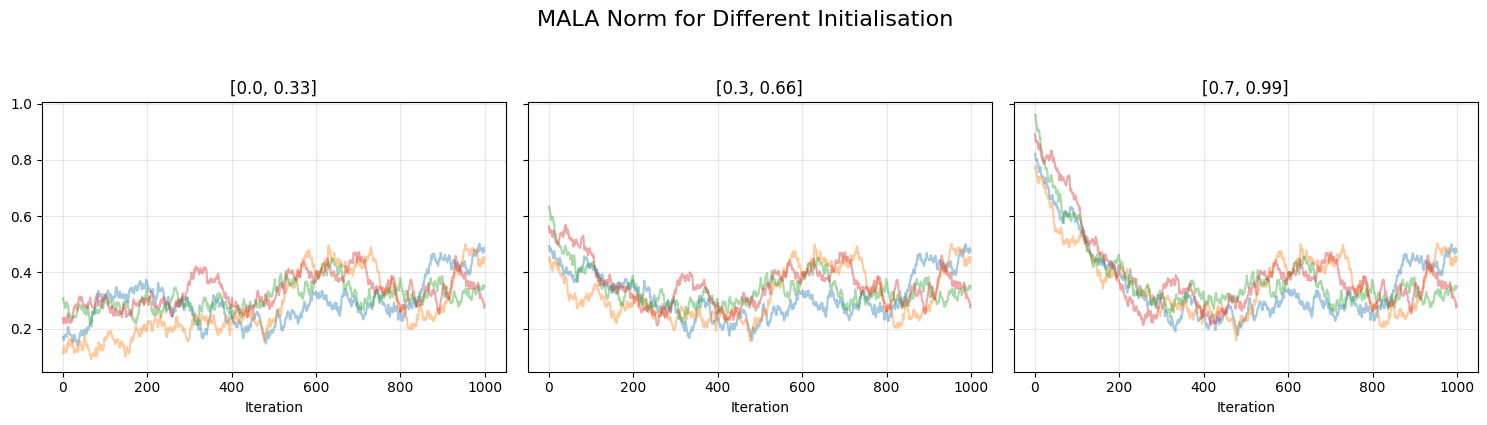

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, sharex=True)
keys = data_dict.keys()
for i, key in enumerate(keys):

    # 1. Get the samples
    beta_samples = data_dict[key][0]
    beta_samples.shape


    # 2. CALCULATE FIRST
    beta_norms = jnp.linalg.norm(beta_samples, axis=-1)


    # 3. THEN PLOT
    ax = axes[i]
    ax.plot(beta_norms.T, alpha=0.4)

    ax.set_title(key)
    ax.set_xlabel("Iteration")

    ax.grid(True, alpha=0.3)

# Move tight_layout outside the loop for better performance
fig.suptitle("MALA Norm for Different Initialisation", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()